<a href="https://colab.research.google.com/github/LueMar-R/P35_Traitement_Caryotypes/blob/main/Classification_chromosomes_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification des chromosomes

<hr>

- <a href='#3'>Préparation des données</a>
- <a href='#4'>Entrainement du modèle de reconnaissance des chromosomes</a>
- <a href='#5'>Résultats</a> 

<hr>

### <a id='1'>Prévisualisation des données</a>

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
%cd '/content/drive/MyDrive/P35_Segmentation_chromosomes'

/content/drive/MyDrive/P35_Segmentation_chromosomes


In [3]:
!unzip data/chro.zip

Archive:  data/chro.zip
replace labels.npy? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: labels.npy              
  inflating: X_mono.npy              


In [3]:
%ls

base_donnees.zip         data/                       O201606.003.A.TIF
chromosom_classifier_1/  labels.npy                  O201618.011.A.TIF
chromosom_classifier_2/  Notes_chromosomes_seg.gdoc  o201632.009.A.TIF
chromosom_classifier_3/  O201577.017.A.TIF           X_mono.npy
cmat.png                 O201583.014.A.TIF


In [5]:
import os
import sys
import numpy as np
import time
import cv2
import random

from glob import glob

from sklearn.metrics import accuracy_score, confusion_matrix

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from keras.layers import Conv2D, Dense, MaxPooling2D, Flatten, Dropout
from keras import Sequential
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical


tf.random.set_seed(8449744397167270535)
random.seed(8449744397167270535)

In [6]:
#nous accédons aux données depuis le dossier dans lequel elles sont stockées
with open('X_mono.npy', 'rb') as f: 
    X = np.load(f )
with open('labels.npy', 'rb') as f: 
    Y = np.load(f )

print("nombre d'images/labels :",len(X), len(Y))

NUM_CLASS = len(np.unique(Y))
print("nombre de classes :", NUM_CLASS)

print("taille des images :", X[0].shape)

print("nombre d'image de chaque classe :")
unique, counts = np.unique(Y, return_counts=True)
distrib = dict(zip(unique, counts))
print(distrib)

nombre d'images/labels : 8441 8441
nombre de classes : 24
taille des images : (128, 128)
nombre d'image de chaque classe :
{0: 379, 1: 364, 2: 386, 3: 365, 4: 365, 5: 374, 6: 364, 7: 364, 8: 372, 9: 365, 10: 366, 11: 365, 12: 364, 13: 363, 14: 365, 15: 366, 16: 364, 17: 364, 18: 365, 19: 364, 20: 366, 21: 368, 22: 280, 23: 83}


In [7]:
LABELS = {0: "c1", 1: "c2", 2: "c3", 3: "c4", 4: "c5", 5: "c6", 6: "c7", 
          7: "c8", 8: "c9", 9: "c10", 10: "c11", 11: "c12", 12: "c13", 
          13: "c14", 14: "c15", 15: "c16", 16: "c17", 17: "c18", 18: "c19", 
          19: "c20", 20: "c21", 21:"c22", 22: "cX", 23: "cY"}

### <a id='3'>Préparation des données</a>

###### Création des sets d'entraînement et de test

In [8]:
# mélange des données
index = np.random.permutation([i for i in range(len(X))])

X = np.asarray(X, dtype=np.uint8)[index]
Y = np.asarray(Y, dtype=np.uint8)[index]

print(X.shape)
print(Y.shape)

(8441, 128, 128)
(8441,)


In [9]:
# séparation
valsplit = len(X)//5
X_train = X[:valsplit*3]
y_train = Y[:valsplit*3]
X_val = X[valsplit*3:valsplit*4]
y_val = Y[valsplit*3:valsplit*4]
X_test = X[valsplit*4:]
y_test = Y[valsplit*4:]
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(5064, 128, 128) (5064,)
(1688, 128, 128) (1688,)
(1689, 128, 128) (1689,)


Visualisations

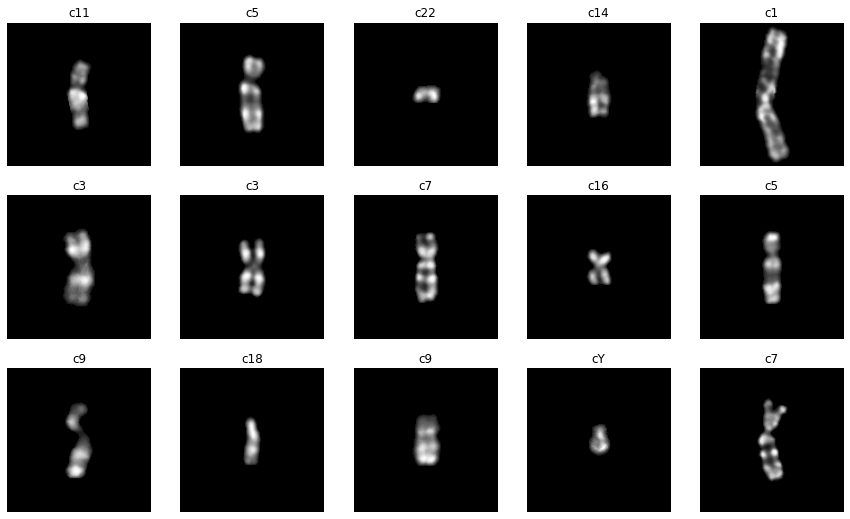

In [9]:
# visualisation
plt.figure(figsize=(15,9))
for i in range(15):
    plt.subplot(3,5,i+1)
    plt.imshow((X_train[i]), cmap='gray')
    plt.title(LABELS[y_train[i]])
    plt.axis('off')
plt.show()

###### Prétraitement en vue de l'entrainement avec un CNN Séquentiel 

In [13]:
print(np.max(X_train), np.min(X_train)) # standardisation nécessaire

255 0


In [14]:
# standardisation, redimensionnement des features
X_train, X_val, X_test = [xx / 255. for xx in [X_train, X_val, X_test ]]
# ajout d'une dimension batch
X_train, X_val, X_test = [np.expand_dims(xx,3) for xx in [X_train, X_val, X_test ]]


In [12]:
# encodage de la target
Y_train = to_categorical(y_train, num_classes=NUM_CLASS)
Y_val = to_categorical(y_val, num_classes=NUM_CLASS)


In [13]:
# vérificationpour un élément au hasard du set d'entrainement
print(Y_train[42], y_train[42], LABELS[y_train[42]]) 

[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 8 c9


In [14]:
# vérificationpour un élément au hasard du set de test
print(Y_val[42], y_val[42], LABELS[y_val[42]]) #test

[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 2 c3


### <a id='4'>Entraînement du modèle</a>

###### Création du modèle séquentiel

In [15]:
modelX = models.Sequential()

modelX.add(Conv2D(64, 7, padding="same", activation='relu', input_shape=(128,128,1)))
modelX.add(MaxPooling2D(2))
modelX.add(Dropout(0.5))
modelX.add(Conv2D(64, 3, padding="same", activation='relu'))
modelX.add(MaxPooling2D(2))
modelX.add(Dropout(0.5))
modelX.add(Conv2D(128, 3, padding="same", activation='relu'))
modelX.add(MaxPooling2D(2))
modelX.add(Dropout(0.5))
modelX.add(Flatten())
modelX.add(Dense(64, activation="relu"))
modelX.add(Dropout(0.25))
modelX.add(Dense(32, activation="relu"))
modelX.add(Dropout(0.25))
modelX.add(Dense(NUM_CLASS, activation='softmax'))

In [17]:
# premier entraînement avec Adamax
modelX.compile(optimizer=optimizers.Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [19]:
BATCH_SIZE = 20
EPOCHS = 200

train_datagen = ImageDataGenerator(
        rotation_range=40,
        horizontal_flip=True,
        fill_mode='constant',
        cval=0.0)

val_datagen = ImageDataGenerator(
        rotation_range=40,
        horizontal_flip=True,
        fill_mode='constant',
        cval=0.0)

train_generator = train_datagen.flow(
        X_train, Y_train, 
        batch_size=BATCH_SIZE)

# this is a similar generator, for validation data
validation_generator = val_datagen.flow(
        X_val, Y_val, 
        batch_size=BATCH_SIZE)

In [20]:
history = modelX.fit(train_generator,
                     steps_per_epoch=len(X_train) // BATCH_SIZE,
                     validation_data=validation_generator,
                     validation_steps=len(X_val) // BATCH_SIZE //2,
                     epochs=EPOCHS)

Epoch 1/200
253/253 [==============================] - 15s 51ms/step - loss: 3.0117 - accuracy: 0.1011 - val_loss: 2.8010 - val_accuracy: 0.2357
Epoch 2/200
253/253 [==============================] - 12s 49ms/step - loss: 2.6197 - accuracy: 0.2026 - val_loss: 2.3689 - val_accuracy: 0.3357
Epoch 3/200
253/253 [==============================] - 12s 48ms/step - loss: 2.4332 - accuracy: 0.2488 - val_loss: 2.2433 - val_accuracy: 0.3857
Epoch 4/200
253/253 [==============================] - 12s 49ms/step - loss: 2.2948 - accuracy: 0.2851 - val_loss: 1.9642 - val_accuracy: 0.4381
Epoch 5/200
253/253 [==============================] - 13s 50ms/step - loss: 2.1787 - accuracy: 0.3176 - val_loss: 1.9433 - val_accuracy: 0.4881
Epoch 6/200
253/253 [==============================] - 14s 55ms/step - loss: 2.0941 - accuracy: 0.3412 - val_loss: 1.7994 - val_accuracy: 0.5250
Epoch 7/200
253/253 [==============================] - 13s 50ms/step - loss: 2.0212 - accuracy: 0.3571 - val_loss: 1.7397 - val_ac

In [21]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

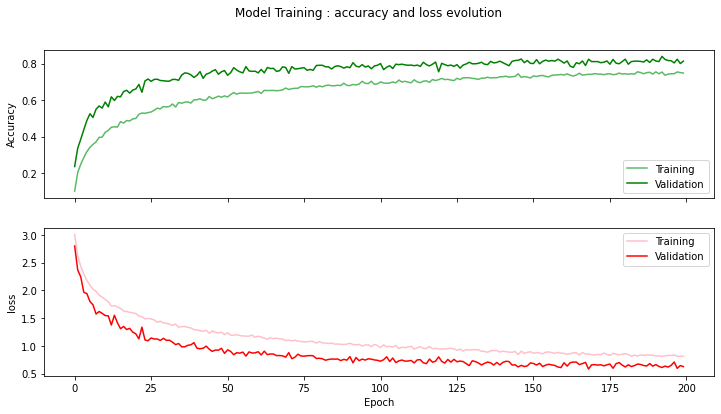

In [22]:
x = list(range(len(loss)))

fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(12,6))
fig.suptitle('Model Training : accuracy and loss evolution')
ax1.plot(x, accuracy, color='#5aba66')
ax1.plot(x, val_accuracy, color='green')
ax1.set_ylabel('Accuracy')
ax1.legend(['Training', 'Validation'], loc='lower right')
ax2.plot(x, loss,  color='pink')
ax2.plot(x, val_loss,  color='red')
ax2.set_ylabel('loss')
ax2.set_xlabel('Epoch')
ax2.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [23]:
#modelX.save('chromosom_classifier_3')

INFO:tensorflow:Assets written to: chromosom_classifier_3/assets


In [20]:
modelX = models.load_model('chromosom_classifier_3')

In [21]:
# second entrainement en affinant les parametres 
modelX.compile(optimizer=optimizers.Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [22]:
history2 = modelX.fit(train_generator,
                     steps_per_epoch=len(X_train) // BATCH_SIZE,
                     validation_data=validation_generator,
                     validation_steps=len(X_val) // BATCH_SIZE //2,
                     epochs=EPOCHS)

Epoch 1/200
253/253 [==============================] - 44s 56ms/step - loss: 0.9193 - accuracy: 0.7254 - val_loss: 0.6156 - val_accuracy: 0.8321
Epoch 2/200
253/253 [==============================] - 13s 50ms/step - loss: 0.8914 - accuracy: 0.7318 - val_loss: 0.5376 - val_accuracy: 0.8524
Epoch 3/200
253/253 [==============================] - 12s 48ms/step - loss: 0.8843 - accuracy: 0.7377 - val_loss: 0.5770 - val_accuracy: 0.8310
Epoch 4/200
253/253 [==============================] - 12s 48ms/step - loss: 0.9119 - accuracy: 0.7320 - val_loss: 0.6201 - val_accuracy: 0.8488
Epoch 5/200
253/253 [==============================] - 12s 48ms/step - loss: 0.8760 - accuracy: 0.7324 - val_loss: 0.5324 - val_accuracy: 0.8643
Epoch 6/200
253/253 [==============================] - 12s 48ms/step - loss: 0.8522 - accuracy: 0.7462 - val_loss: 0.5261 - val_accuracy: 0.8548
Epoch 7/200
253/253 [==============================] - 12s 48ms/step - loss: 0.8830 - accuracy: 0.7294 - val_loss: 0.5226 - val_ac

In [23]:
modelX.save('chromosom_classifier_4')

INFO:tensorflow:Assets written to: chromosom_classifier_4/assets


In [10]:
#!zip -r chromosom_classifier_4.zip chromosom_classifier_4

  adding: chromosom_classifier_4/ (stored 0%)
  adding: chromosom_classifier_4/variables/ (stored 0%)
  adding: chromosom_classifier_4/variables/variables.data-00000-of-00001 (deflated 20%)
  adding: chromosom_classifier_4/variables/variables.index (deflated 67%)
  adding: chromosom_classifier_4/assets/ (stored 0%)
  adding: chromosom_classifier_4/saved_model.pb (deflated 89%)
  adding: chromosom_classifier_4/keras_metadata.pb (deflated 92%)


###### Validation sur la base de données de test

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Nous allons mainteant évaluer nos résulats grâce à nos données de test

In [10]:
modelX = models.load_model('chromosom_classifier_4')

In [19]:
X_test.shape

(1689, 128, 128, 1)

In [15]:
Y_pred = modelX.predict(X_test)

In [16]:
y_pred=[]
for y in Y_pred:
    y_pred.append(np.argmax(y))

In [17]:
cf_matrix = confusion_matrix(y_test, y_pred)

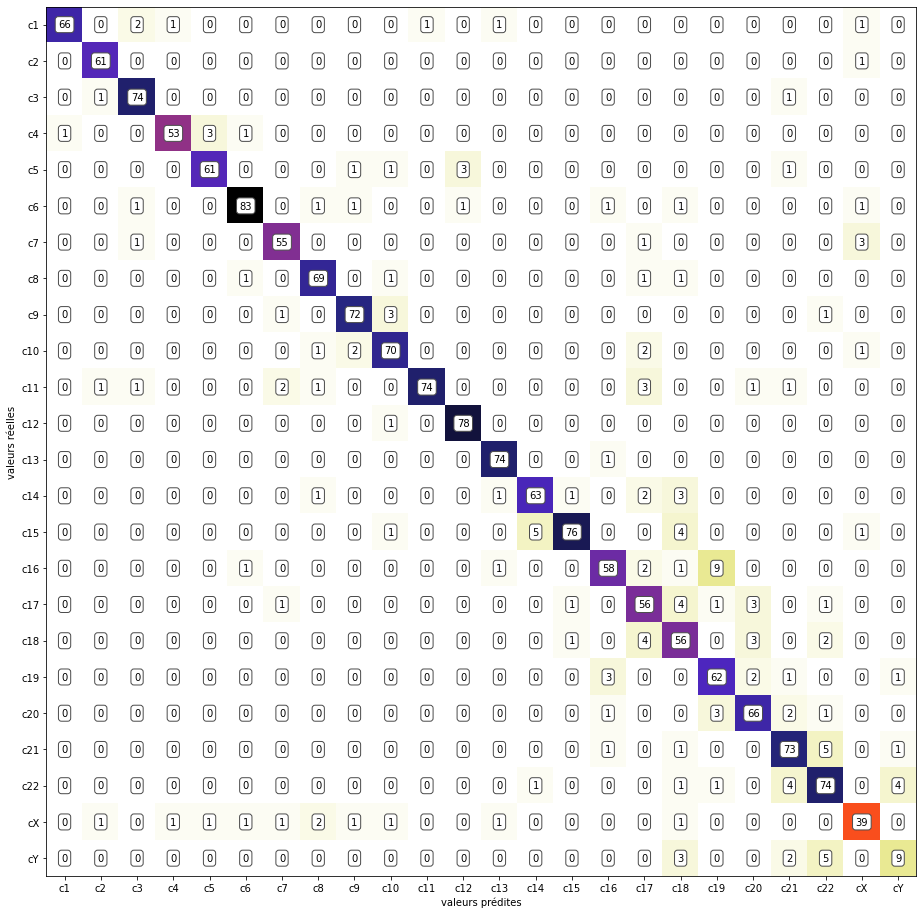

<Figure size 432x288 with 0 Axes>

In [18]:
plt.figure(figsize=(16,16))
plt.imshow(cf_matrix, cmap="CMRmap_r")
for (i, j), z in np.ndenumerate(cf_matrix):
    plt.text(j, i, z, ha='center', va='center', bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3'))
plt.xlabel("valeurs prédites")
plt.xticks(ticks =[i for i in range(len(LABELS))], labels=[LABELS[i] for i in range(len(LABELS))])
plt.ylabel("valeurs réelles")
plt.yticks(ticks =[i for i in range(len(LABELS))], labels=[LABELS[i] for i in range(len(LABELS))])
plt.show()
plt.savefig("cmat.png")


In [20]:
accuracy_score(y_test, y_pred)

0.9011249259917111

### <a id='5'>Résultats</a>

Les chromosomes sont globalement bien reconnus et classifiés, excepté le chromosome Y.